<a href="https://colab.research.google.com/github/yonathanarbel/AI-LAW/blob/main/Learning_Decision_Trees_and_Neural_Networks_from_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Let's learn Neural Networks from the ground up.

Suppose we have a stylized trial. There are four opportunities or "turns" during trial for either side to raise an argument. The parties move sequentially, so the first argument is by the plaintiff (at whatever turn), the second (at whatever turn) is by the defense, and so on. By default, if no argument is raised, the defense wins. (we are adapting here the classic "input parity problem").

Below we have a table with past experience. We see how many arguments were raised and then the outcome. 1 means defense wins, 0 means the plaintiff. Review the table for a second and see if you can come up with a rule of who wins when.

1 2 3 4  | Output
-----------------------------------|-------
   0        0        0        0     |   1
   0        0        0        1     |   0
   0        0        1        0     |   0
   0        0        1        1     |   1
   0        1        0        0     |   0
   0        1        0        1     |   1
   0        1        1        0     |   1
   0        1        1        1     |   0
   1        0        0        0     |   0
   1        0        0        1     |   1
   1        0        1        0     |   1
   1        0        1        1     |   0
   1        1        0        0     |   1
   1        1        0        1     |   0
   1        1        1        0     |   0
   1        1        1        1     |   1


We want a model that can learn this rule on its own. It will take a series of arguments and predict the outcome correctly.

Our first step in building the network is the input. How many inputs do we have?

The last step is the output. We want a simple yes/no answer. So how many outputs do we want?

The middle step is the tricky one. We create the "hidden layer." How many nodes should we put in here? Why do we even need a hidden layer to begin with?

The code below builds a neural network from scratch, just using logic and code in Python. In practice, nobody would do this as it is tedious and for a large network, very difficult. Only "researchers" developing new neural networks would create the network from scratch, which would then be convereted into a function and subsequently deployed in industry at scale.

Doing this from scratch allows us to see the mechanisms we discussed above in action. Let's go through the code and try to decipher what is going on and how it works!

In [1]:
# First, some stuff we need
!pip install scikit-learn pandas matplotlib keras tensorflow -q
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_curve, auc
import random
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
import random

In [2]:
# Define dataset
inputs = [
    [0, 0, 0, 0],
    [0, 0, 0, 1],
    [0, 0, 1, 0],
    [0, 0, 1, 1],
    [0, 1, 0, 0],
    [0, 1, 0, 1],
    [0, 1, 1, 0],
    [0, 1, 1, 1],
    [1, 0, 0, 0],
    [1, 0, 0, 1],
    [1, 0, 1, 0],
    [1, 0, 1, 1],
    [1, 1, 0, 0],
    [1, 1, 0, 1],
    [1, 1, 1, 0],
    [1, 1, 1, 1]
]

outputs = [1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1]


# Create DataFrame
df = pd.DataFrame(inputs, columns=['Turn_1', 'Turn_2', 'Turn_3', 'Turn_4'])
df['Outcome'] = outputs

# Display the table
print(df)


    Turn_1  Turn_2  Turn_3  Turn_4  Outcome
0        0       0       0       0        1
1        0       0       0       1        0
2        0       0       1       0        0
3        0       0       1       1        1
4        0       1       0       0        0
5        0       1       0       1        1
6        0       1       1       0        1
7        0       1       1       1        0
8        1       0       0       0        0
9        1       0       0       1        1
10       1       0       1       0        1
11       1       0       1       1        0
12       1       1       0       0        1
13       1       1       0       1        0
14       1       1       1       0        0
15       1       1       1       1        1


Initial random weights and biases:
weights_input_hidden: [[0.06669624580946776, -0.9526933954444985, -0.8861985044389322, 0.5271731015403123], [0.7588275391152248, 0.9408606296806004, -0.4806657263168117, -0.15236772999906156], [-0.15394179092745763, -0.37319854776806727, -0.268231427919438, 0.8833619365968379], [0.20909284805895267, -0.7689014042889266, -0.8431977902149761, 0.1671609102690439]]
weights_hidden_output: [-0.2961424073974883, 0.9273531647695423, 0.702886990058035, -0.3078873565983926]
biases_hidden: [-0.46828765340017875, -0.32111236833026036, 0.7366022447770086, -0.48089675675533217]
bias_output: -0.34843935931292624


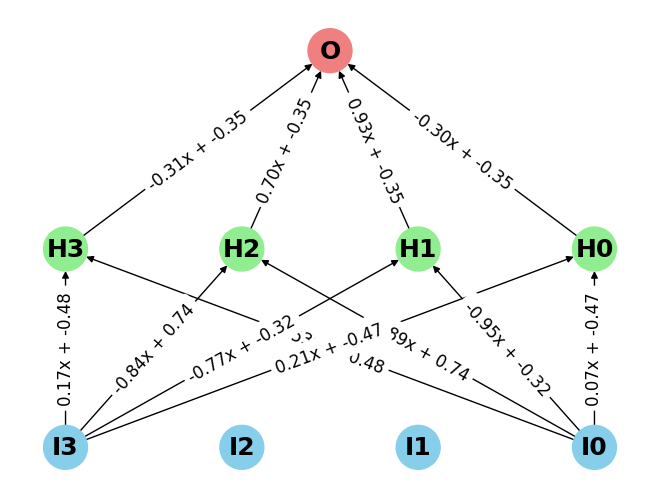

In [3]:

#We start be defining the structure of our network:
input_size = 4
hidden_size = 4
output_size = 1

#Now, the way the network works is by taking inputs, multiplying them by some number (weight) adding to them some other numbers (bias) and then "squishes" the numbers to be between 0 and 1

weights_input_hidden = [[random.uniform(-1, 1) for _ in range(hidden_size)] for _ in range(input_size)]
weights_hidden_output = [random.uniform(-1, 1) for _ in range(hidden_size)]
biases_hidden = [random.uniform(-1, 1) for _ in range(hidden_size)]
bias_output = random.uniform(-1, 1)


#The code below tells us what we have created and visualizes it


# Print initial random weights and biases
print("Initial random weights and biases:")
print(f"weights_input_hidden: {weights_input_hidden}")
print(f"weights_hidden_output: {weights_hidden_output}")
print(f"biases_hidden: {biases_hidden}")
print(f"bias_output: {bias_output}")

# Set random seed for reproducibility
random.seed(42)

# Define structure
input_size = 4
hidden_size = 4
output_size = 1


# Initialize graph
G = nx.DiGraph()

# Add nodes with 'layer' attribute
for i in range(input_size):
    G.add_node(f'I{i}', layer=0)
for i in range(hidden_size):
    G.add_node(f'H{i}', layer=1)
G.add_node('O', layer=2)

# Add edges with equation as attribute
for i in [0, 3]:  # First and fourth inputs only
    for j in range(hidden_size):
        G.add_edge(f'I{i}', f'H{j}', label=f'{weights_input_hidden[i][j]:.2f}x + {biases_hidden[j]:.2f}')
for i in range(hidden_size):
    G.add_edge(f'H{i}', 'O', label=f'{weights_hidden_output[i]:.2f}x + {bias_output:.2f}')

# Draw graph
pos = nx.multipartite_layout(G, subset_key="layer", align='horizontal')
nx.draw(G, pos, with_labels=True, node_color=['skyblue']*input_size + ['lightgreen']*hidden_size + ['lightcoral'], font_weight='bold', node_size=1000, font_size=18)
labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=12)

# Show plot
plt.show()


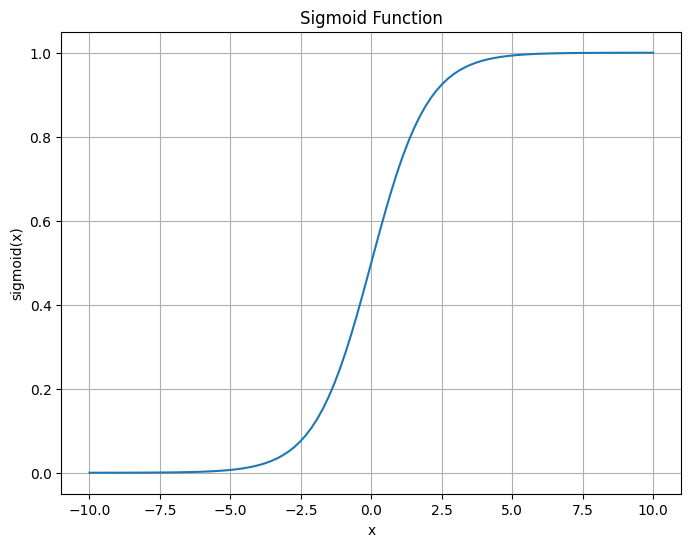

The sigmoid of 3 is 0.952574035657741


In [4]:
#Now comes the "squishing" in all these H0-H3 we take the numbers we get and simply squish them to be in the range of 0-1.
#We use a math  function called sigmoid. We define it here (and its derivative for later) and then visualize how it works

# Define sigmoid function and its derivative
# The sigmoid function is our activation function
def sigmoid(x):
    return 1 / (1 + 2.71828 ** -x) # 2.718281828459045 is the number 'e'

def sigmoid_derivative(x):
    return x * (1 - x)


#This is what the sigmoid function looks like

# Create data points for visualization
x = np.linspace(-10, 10, 100)
y = sigmoid(x)

# Visualize sigmoid function
plt.figure(figsize=(8, 6))
plt.plot(x, y)
plt.title('Sigmoid Function')
plt.xlabel('x')
plt.ylabel('sigmoid(x)')
plt.grid(True)
plt.show()

#try to see how it squishes numbers

n= 3
print (f"The sigmoid of {n} is {sigmoid(n)}")

#Each node (besides the input) has a sigmoid in it.
#Now, at the last node, the output node, it gets all the numbers, squishes them together, and runs them through a sigmoid
#If the sigmoid > 0.5, then we classify the result as 1, otherwise, 0.

In [5]:
#Now, here's how training/learning happens
#The model makes predictions based on its weights and biases. The prediction is something like 0.03 or 0.78
#the real answer is always 0 or 1
#The model asks: for each weight and bias, in which direction should I change it such that our predictions would come closer to the real answer?
#If it's down, it adjusts it down. Exactly how much it adjusts it is defined by something called the learning rate, which is not particularly important for us

learning_rate = 0.1

#With every new example, the model readjusts its weights and biases. But that means that the model can adjust away from the initial examples to better predict the latter examples
#So we often run it over the data a number of times. We call each run an "epoch"

#Let's start with a puny 1 epoch run

epochs = 1
for epoch in range(epochs):
    total_error = 0
    for i in range(len(inputs)):
        # Forward Propagation
        hidden_layer_input = [sum([inputs[i][j] * weights_input_hidden[j][k] for j in range(input_size)]) + biases_hidden[k] for k in range(hidden_size)]
        hidden_layer_output = [sigmoid(x) for x in hidden_layer_input]

        final_input = sum([hidden_layer_output[j] * weights_hidden_output[j] for j in range(hidden_size)]) + bias_output
        final_output = sigmoid(final_input)

        # Compute Error
        error = outputs[i] - final_output
        total_error += error ** 2


        # Backward Propagation
        d_output = error * sigmoid_derivative(final_output)

        d_hidden_layer = [d_output * weights_hidden_output[j] * sigmoid_derivative(hidden_layer_output[j]) for j in range(hidden_size)]

        # Update Weights and Biases
        for j in range(hidden_size):
            weights_hidden_output[j] += learning_rate * d_output * hidden_layer_output[j]

        for j in range(input_size):
            for k in range(hidden_size):
                weights_input_hidden[j][k] += learning_rate * d_hidden_layer[k] * inputs[i][j]

        for j in range(hidden_size):
            biases_hidden[j] += learning_rate * d_hidden_layer[j]

        bias_output += learning_rate * d_output

    # Print error for every 1000 epochs
    if epoch % 1000 == 0:
        print(f'Error at epoch {epoch}: {total_error}')



Error at epoch 0: 4.112802456252362


Model Accuracy: 56.25%


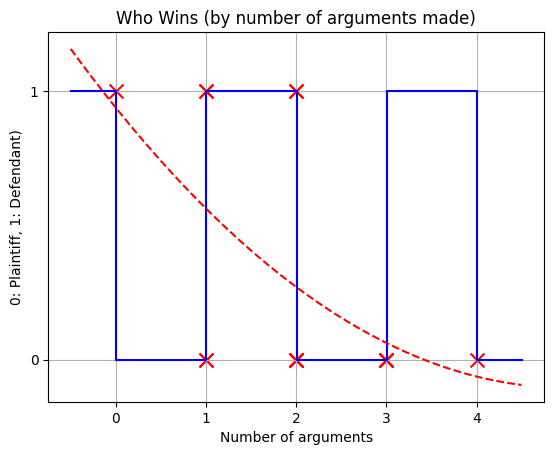

In [6]:
# Function to calculate accuracy
def calculate_accuracy_and_predictions(inputs, weights_input_hidden, biases_hidden, weights_hidden_output, bias_output):
    predicted_outputs = []
    input_size = len(inputs[0])
    hidden_size = len(weights_hidden_output)

    for i in range(len(inputs)):
        # Forward Propagation
        hidden_layer_input = np.dot(inputs[i], weights_input_hidden) + biases_hidden
        hidden_layer_output = sigmoid(hidden_layer_input)
        final_input = np.dot(hidden_layer_output, weights_hidden_output) + bias_output
        final_output = sigmoid(final_input)
        predicted_output = 1 if final_output > 0.5 else 0
        predicted_outputs.append(predicted_output)

    # Calculate accuracy
    def calculate_accuracy(predicted_outputs, actual_outputs):
      correct_predictions = sum(p == a for p, a in zip(predicted_outputs, actual_outputs))
      accuracy = (correct_predictions / len(actual_outputs)) * 100
      return accuracy

    accuracy = calculate_accuracy(predicted_outputs, outputs)
    return accuracy, predicted_outputs

# Make predictions using trained model
predicted_outputs = []
for i in range(len(inputs)):
    # Forward Propagation
    hidden_layer_input = [sum([inputs[i][j] * weights_input_hidden[j][k] for j in range(input_size)]) + biases_hidden[k] for k in range(hidden_size)]
    hidden_layer_output = [sigmoid(x) for x in hidden_layer_input]
    final_input = sum([hidden_layer_output[j] * weights_hidden_output[j] for j in range(hidden_size)]) + bias_output
    final_output = sigmoid(final_input)
    predicted_output = 1 if final_output > 0.5 else 0
    predicted_outputs.append(predicted_output)


# Calculate accuracy and predicted outputs
accuracy, predicted_outputs = calculate_accuracy_and_predictions(inputs, weights_input_hidden, biases_hidden, weights_hidden_output, bias_output)
print(f"Model Accuracy: {accuracy}%")

# Plot original step data
x = np.linspace(-0.5, 4.5, 500)
y = np.floor(x) % 2
plt.step(x, y, where='post', color='blue')

# Annotate and plot red X for predictions
sums = []  # list to store sum of input rows
for i, input_row in enumerate(inputs):
    num_arguments = sum(input_row)
    sums.append(num_arguments)
    plt.scatter(num_arguments, predicted_outputs[i], color='red', marker='x', s=100)

# Fit a polynomial and plot it
z = np.polyfit(sums, predicted_outputs, 3)  # Using a 3rd-degree polynomial for curve fitting
p = np.poly1d(z)
xp = np.linspace(-0.5, 4.5, 500)
plt.plot(xp, p(xp), 'r--')

# Annotations
plt.title('Who Wins (by number of arguments made)')
plt.xlabel('Number of arguments')
plt.ylabel('0: Plaintiff, 1: Defendant)')
plt.xticks(np.arange(0, 5))
plt.yticks([0, 1])
plt.grid(True)

# Show updated plot
plt.show()




Now, let's go back to the original model that worked, but let's use libraries and functions, as anyone coding in industry would.

In [8]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

# Define the inputs and outputs
inputs = np.array([
    [0, 0, 0, 0],
    [0, 0, 0, 1],
    [0, 0, 1, 0],
    [0, 0, 1, 1],
    [0, 1, 0, 0],
    [0, 1, 0, 1],
    [0, 1, 1, 0],
    [0, 1, 1, 1],
    [1, 0, 0, 0],
    [1, 0, 0, 1],
    [1, 0, 1, 0],
    [1, 0, 1, 1],
    [1, 1, 0, 0],
    [1, 1, 0, 1],
    [1, 1, 1, 0],
    [1, 1, 1, 1]
], dtype='float32')

outputs = np.array([1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1], dtype='float32')

# Model definition
model = keras.Sequential()
model.add(layers.Dense(4, activation='sigmoid', input_shape=(4,)))
model.add(layers.Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(inputs, outputs, epochs=10, verbose=0)  # Reduced epochs for faster convergence

# Evaluate the model
loss, accuracy = model.evaluate(inputs, outputs, verbose=0)
print(f"Accuracy: {accuracy*100:.2f}%")

# Predictions
predictions = model.predict(inputs)
rounded_predictions = [round(i[0]) for i in predictions]
print("\nTesting:")
for i, input_data in enumerate(inputs):
    print(f"Input: {input_data.tolist()}, Predicted Output: {rounded_predictions[i]}, True Output: {outputs[i]}")


Accuracy: 50.00%
1/1 [==============================] - 1s 978ms/step

Testing:
Input: [0.0, 0.0, 0.0, 0.0], Predicted Output: 1, True Output: 1.0
Input: [0.0, 0.0, 0.0, 1.0], Predicted Output: 1, True Output: 0.0
Input: [0.0, 0.0, 1.0, 0.0], Predicted Output: 1, True Output: 0.0
Input: [0.0, 0.0, 1.0, 1.0], Predicted Output: 1, True Output: 1.0
Input: [0.0, 1.0, 0.0, 0.0], Predicted Output: 1, True Output: 0.0
Input: [0.0, 1.0, 0.0, 1.0], Predicted Output: 1, True Output: 1.0
Input: [0.0, 1.0, 1.0, 0.0], Predicted Output: 1, True Output: 1.0
Input: [0.0, 1.0, 1.0, 1.0], Predicted Output: 1, True Output: 0.0
Input: [1.0, 0.0, 0.0, 0.0], Predicted Output: 1, True Output: 0.0
Input: [1.0, 0.0, 0.0, 1.0], Predicted Output: 1, True Output: 1.0
Input: [1.0, 0.0, 1.0, 0.0], Predicted Output: 1, True Output: 1.0
Input: [1.0, 0.0, 1.0, 1.0], Predicted Output: 1, True Output: 0.0
Input: [1.0, 1.0, 0.0, 0.0], Predicted Output: 1, True Output: 1.0
Input: [1.0, 1.0, 0.0, 1.0], Predicted Output: 1,

See how much easier that was and how much less code that was? We got the same model performance, but it still wasn't perfect. Any guess on how we can get closer to 100%? Do you think the network below will work? Take a look at its architecture and see what has changed.

In [12]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
X = inputs
y = outputs

# Model definition
model = keras.Sequential([
    layers.Input(shape=(4,)),
    layers.Dense(8, activation='relu'),
    layers.Dense(4, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X, y, epochs=50, verbose=0)

# Evaluation
loss, accuracy = model.evaluate(X, y)
print(f"Accuracy: {accuracy*100:.2f}%")

# Predictions
predictions = model.predict(X)
rounded_predictions = [round(i[0]) for i in predictions]
print("\nTesting:")
for i, input_data in enumerate(X):
    print(f"Input: {input_data}, Predicted Output: {rounded_predictions[i]}, True Output: {y[i]}")

1/1 [==============================] - 0s 493ms/step - loss: 0.6988 - accuracy: 0.5000
Accuracy: 50.00%
1/1 [==============================] - 0s 206ms/step

Testing:
Input: [0. 0. 0. 0.], Predicted Output: 0, True Output: 1.0
Input: [0. 0. 0. 1.], Predicted Output: 1, True Output: 0.0
Input: [0. 0. 1. 0.], Predicted Output: 0, True Output: 0.0
Input: [0. 0. 1. 1.], Predicted Output: 1, True Output: 1.0
Input: [0. 1. 0. 0.], Predicted Output: 1, True Output: 0.0
Input: [0. 1. 0. 1.], Predicted Output: 1, True Output: 1.0
Input: [0. 1. 1. 0.], Predicted Output: 1, True Output: 1.0
Input: [0. 1. 1. 1.], Predicted Output: 1, True Output: 0.0
Input: [1. 0. 0. 0.], Predicted Output: 1, True Output: 0.0
Input: [1. 0. 0. 1.], Predicted Output: 1, True Output: 1.0
Input: [1. 0. 1. 0.], Predicted Output: 1, True Output: 1.0
Input: [1. 0. 1. 1.], Predicted Output: 1, True Output: 0.0
Input: [1. 1. 0. 0.], Predicted Output: 1, True Output: 1.0
Input: [1. 1. 0. 1.], Predicted Output: 1, True Outpu

Here we used two hidden layers, the first with eight nodes and the second with 4 nodes. We also changed some other things about our network like switching from the sigmoid activation function to using both the sigmoid and ReLU activation function (we haven't talked about this, so don't worry about understanding it). Despite adding layers and nodes, we got inconsistant results with this network (and it was more computationally expensive). Do you think you could build a network with better performance?

_________________________________________________________________________

Now it's time for our decision tree, but how do decision trees work?

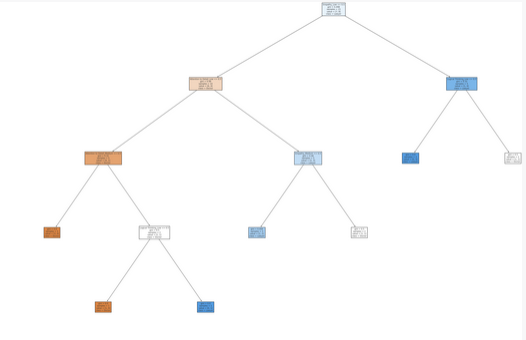

Let's start with a definition and then build the intution together. The defintion from Russell and Norvig's *Ariticial Intelligence* provides a lot of insight: "A decision tree is a representation of a function that maps a vector of attribute values to a single ouput value - a "decision." A decision tree reaches its decision by performing a sequence of tests, starting at the root and following the appropriate branch until a leaf is reached. Each internal node in the tree corresponds to a test of the value of one of the input attributes, the branches from the node are labeled with the possible values of the attribute, and the leaf nodes specify what value is to be returned by the function."

But we want an intution, so here you go: a decision tree is basically like playing 20 questions!


We will now, by hand, build a decision tree classifier, and we will test yours on unseen data. In this version of the game, you are only allowed to ask 2 questions (It's ok if you need 3, but no more!).

The game works like this: you need to find a set of questions that will tell you if a person should be a lawyer or a doctor. We will give you data about a few people. You will use it to build your questions. Then, we will test you on a new person, and see if you can get correctly tell if she should go to law school or med school.



In [13]:
# Creating the dataset as a Python list of dictionaries

dataset = [

    {'Class': 'Lawyer', 'Cat Lover?': 'Yes', 'Likely to Argue on Thanksgiving?': 'High', 'Coffee Drinker?': 'Yes'},

    {'Class': 'Lawyer', 'Cat Lover?': 'Yes', 'Likely to Argue on Thanksgiving?': 'Medium', 'Coffee Drinker?': 'Yes'},

    {'Class': 'Lawyer', 'Cat Lover?': 'No', 'Likely to Argue on Thanksgiving?': 'High', 'Coffee Drinker?': 'No'},

    {'Class': 'Doctor', 'Cat Lover?': 'Yes', 'Likely to Argue on Thanksgiving?': 'Low', 'Coffee Drinker?': 'Yes'},

    {'Class': 'Doctor', 'Cat Lover?': 'No', 'Likely to Argue on Thanksgiving?': 'Medium', 'Coffee Drinker?': 'Yes'},

    {'Class': 'Doctor', 'Cat Lover?': 'No', 'Likely to Argue on Thanksgiving?': 'High', 'Coffee Drinker?': 'Yes'}

]




# Displaying the dataset

# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(dataset)

# Display the DataFrame in Colab
print(df)

    Class Cat Lover? Likely to Argue on Thanksgiving? Coffee Drinker?
0  Lawyer        Yes                             High             Yes
1  Lawyer        Yes                           Medium             Yes
2  Lawyer         No                             High              No
3  Doctor        Yes                              Low             Yes
4  Doctor         No                           Medium             Yes
5  Doctor         No                             High             Yes


In [14]:
# @title Spoiler!
#spoiler: solution
# Create a directed graph for the revised decision tree

'''
- Is "Likely to Argue on Thanksgiving?" High, Medium, or Low?
  ├─ High:
  │    └─ Is "Cat Lover?" Yes or No?
  │        ├─ Yes: [Lawyer]
  │        └─ No:
  │             └─ Is "Coffee Drinker?" Yes or No?
  │                  ├─ Yes: [Doctor]
  │                  └─ No: [Lawyer]
  ├─ Medium:
  │    └─ Is "Cat Lover?" Yes or No?
  │        ├─ Yes: [Lawyer]
  │        └─ No: [Doctor]
  └─ Low: [Doctor]

'''



'\n- Is "Likely to Argue on Thanksgiving?" High, Medium, or Low?\n  ├─ High:\n  │    └─ Is "Cat Lover?" Yes or No?\n  │        ├─ Yes: [Lawyer]\n  │        └─ No:\n  │             └─ Is "Coffee Drinker?" Yes or No?\n  │                  ├─ Yes: [Doctor]\n  │                  └─ No: [Lawyer]\n  ├─ Medium:\n  │    └─ Is "Cat Lover?" Yes or No?\n  │        ├─ Yes: [Lawyer]\n  │        └─ No: [Doctor]\n  └─ Low: [Doctor]\n\n'

Now, we are going to teach machines to make credit decisions. We will have people apply for personal credit, and we will build an algorithm that will help us decide whether to extend them credit or not.

In the process of doing so, we will learn how to build two types of models: decision trees and a neural network.

You know a little bit about neural networks, but we haven't discussed decision trees. There isn't anything remarkable about decision trees; they are just another machine learning model that is used frequently.

Let's dive in!

Last class we focused on data. We saw how biased data fed into even sophisticated models with lots of parameters can result in a biased outcome (recall the dataset biased against redheads). This week we are focusing more on the models themselves, particularly neural networks, but we still need data.

Below we will prepare our data, which is a dataset of German credit data - "This dataset classifies people described by a set of attributes as good or bad credit risks."

So, printing the data's columns isn't super helpful. Let's look at the raw data: https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data-numeric. That's not very helpful either.

But fortunately there's a nice write up of the data: https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data

Let's study the data we have.

Questions for you:
1. What's a feature? What's a target?
2. What types of features do you see here? What do they mean?
3. Why do we need the unt column?
4. How did the Germans decide what's good and bad? Is this a sensible way to measure credit risk?
----

Look at the features. Which do YOU think are the most important ones to predict creditworthiness? Choose top 3

What did we learn here?

1. We have nodes.
2. The best algorithm will choose the questions that "discriminate" the best (or maximize information gain which is identical to minimizing entropy)
3. You may start to get a sense of what overfitting is.




We want to train a credit risk model. There are two fundamental steps that are involved.

1. We have a list of columns. What are we tryng to predict?
2. How would we know if we built a good model?

Both questions are not trivial. The first one is about understanding your goals on a deep level. You may be tempted to say "In building a credit extension model, we should try to predict who defaults and who doesn't." But this is naive! In fact, financial institutions (for better or worse!) care about different things. A customer in default may in fact be more valuable to the bank than one who pays everything on time!

The second question requires an understanding of the problem of *overfitting*

This suggests the need for a *training* and *test* datasets.





In [15]:
# Load dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data-numeric"
data = pd.read_csv(url, delim_whitespace=True)


In [16]:
#what did we just load?

# Print the column names
print(data.columns)

Index(['1', '6', '4', '12', '5', '5.1', '3', '4.1', '1.1', '67', '3.1', '2',
       '1.2', '2.1', '1.3', '0', '0.1', '1.4', '0.2', '0.3', '1.5', '0.4',
       '0.5', '1.6', '1.7'],
      dtype='object')


In [17]:
#let's use it and give our data more descriptive names.
#Go ahead: change the names yourself
new_column_names = {
    'Attribute1': 'name1',
    'Attribute2': 'name2',
    'Attribute3': 'name3',
    'Attribute4': 'name4',
    'Attribute5': 'name5',
    'Attribute6': 'name6',
    'Attribute7': 'name7',
    'Attribute8': 'name8',
    'Attribute9': 'name9',
    'Attribute10': 'name10',
    'Attribute11': 'name11',
    'Attribute12': 'name12',
    'Attribute13': 'name13',
    'Attribute14': 'name14',
    'Attribute15': 'name15',
    'Attribute16': 'name16',
    'Attribute17': 'name17',
    'Attribute18': 'name18',
    'Attribute19': 'name19',
    'Attribute20': 'name20',
    'class': 'Class'
}

# Rename columns
data.rename(columns=new_column_names, inplace=True)
print("Columns renamed.")


Columns renamed.


In [18]:
#As always, EDA. Let's look at each attribute and see which values it has, just to make sure it's sensible
# Generate summary statistics for each attribute
# Temporarily display all columns and rows in pandas output
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Generate summary statistics for each attribute
summary_stats = data.describe(include='all')
print("Summary Statistics:")
print(summary_stats)

# Reset display settings to default
pd.reset_option('display.max_columns')
pd.reset_option('display.max_rows')



Summary Statistics:
                1           6           4          12           5         5.1  \
count  999.000000  999.000000  999.000000  999.000000  999.000000  999.000000   
mean     2.578579   20.917918    2.543544   32.731732    2.102102    3.382382   
std      1.257276   12.055619    1.082682   28.259145    1.578153    1.207828   
min      1.000000    4.000000    0.000000    2.000000    1.000000    1.000000   
25%      1.000000   12.000000    2.000000   14.000000    1.000000    3.000000   
50%      2.000000   18.000000    2.000000   23.000000    1.000000    3.000000   
75%      4.000000   24.000000    4.000000   40.000000    3.000000    5.000000   
max      4.000000   72.000000    4.000000  184.000000    5.000000    5.000000   

                3         4.1         1.1          67         3.1           2  \
count  999.000000  999.000000  999.000000  999.000000  999.000000  999.000000   
mean     2.681682    2.843844    2.359359   35.514515    2.674675    1.406406   
std    

In [19]:
# Separating features and target
X = data.iloc[:, :-1]
#we are going to make sure the target is either 1 or a 0. In the original it's either 1 or 2, so we will change 1 to 0 and 2 to 1.
y = data.iloc[:, -1].apply(lambda x: 1 if x == 2 else 0)  # Converting to binary classification problem

# Splitting dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#We will not talk about standartizing features unless you are very interested, but in essence the idea is we make everything be on the same scale
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

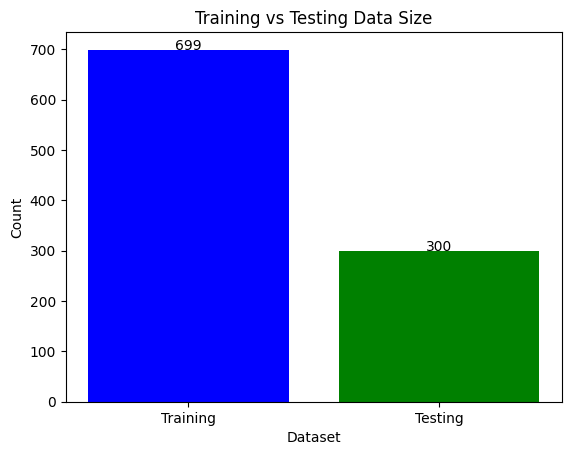

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
labels = ['Training', 'Testing']
counts = [len(X_train), len(X_test)]

# Plotting
plt.bar(labels, counts, color=['blue', 'green'])
plt.xlabel('Dataset')
plt.ylabel('Count')
plt.title('Training vs Testing Data Size')

# Add text annotations on the bars
for i, count in enumerate(counts):
    plt.text(i, count, str(count), ha='center')

plt.show()


-------

And now, we can go back to our credit model. This time, with so many features, we don't want to do it by hand. So we will let the computer build the model itself.

It will (roughly) inquire: look at the nodes. Which question or decision criteria gives me the best information split?


In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Train a decision tree model
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred_dt = dt_classifier.predict(X_test_scaled)
print(f"Decision Tree Accuracy: {accuracy_score(y_test, y_pred_dt)}")

Decision Tree Accuracy: 0.6933333333333334


Here's what the code is doing:

Training the Model: The dt_classifier.fit(X_train_scaled, y_train) part of the code is where the decision tree model is trained on the "training set" (X_train_scaled and y_train). Here the model is learning to make predictions based on the features (X_train_scaled) and their corresponding labels (y_train).

Applying the Model to Unseen Data: After the model has been trained, it's then used to make predictions on the "test set" The line y_pred_dt = dt_classifier.predict(X_test_scaled) is where the model is applied to the test set (X_test_scaled). As you know, the test set consists of data that the model has not seen during its training phase. It's used to simulate how the model would perform in a real-world scenario, making predictions on new, unseen data.

Evaluating Model Performance: The accuracy reported (0.67 or 67%) from accuracy_score(y_test, y_pred_dt) measures how well the model's predictions on the test set (y_pred_dt) matched the actual labels of the test data (y_test). In this case, an accuracy of 67% means that the model correctly predicted the label for 67% of the cases in the test set.

Now let's see how well it modeled the training set!

In [22]:
# Predict on the training set
y_train_pred = dt_classifier.predict(X_train_scaled)

# Calculate accuracy on the training set
train_accuracy = accuracy_score(y_train, y_train_pred)

# Print out training and test accuracies
print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_dt):.2f}")

Training Accuracy: 1.00
Test Accuracy: 0.69


So how did our decison tree do?

There are techniques we could use to likely improve the performance of our decision tree, such as pruning, which combats overfitting. But what is overfitting and how do we know when our model is overfitting?

Overfitting loosely is when the model does well for the training data but does much worse on the new unseen data. Rather than dive into the math, let's think about how this might look graphically. Let's draw on the board some data points on a graph and then a line fitting the data that we think "overfits" the data. Is there an animal that you think might look like this line? Why do you think fitting the training data too well is a problem? Think critically and think about examples from your own life!

So with our discrepancy between training performance and test performance, we are likely overfitting! Also, we can take comfort in our conclusion that we are overfitting due to the fact that overfitting becomes more likely as the number of attributes grows. Does this sound familiar? One of the themes of this course is that models can behave badly. Although perhaps counterintuitive, a model with too many parameters is perhaps just overengineered. Lots of models have failed due to having too many parameters. Now, back to pruning.

Time to take out our shears! Pruning works by eliminating nodes that are not relevant. So how do we know which nodes to eliminate, meaning how do we know to eliminate a node that is testing an irrelevant attribute? We look for nodes with low information gain and then set the information gain requriement using a statistical distribution, and again we will not go into futher detail on this (#nomath).


In [23]:
# Re-train decision tree with limited depth
dt_classifier_pruned = DecisionTreeClassifier(random_state=42, max_depth=3)
dt_classifier_pruned.fit(X_train_scaled, y_train)

# Predict and evaluate on both training and test setsa
y_train_pred_pruned = dt_classifier_pruned.predict(X_train_scaled)
y_test_pred_pruned = dt_classifier_pruned.predict(X_test_scaled)

print(f"Pruned Tree Training Accuracy: {accuracy_score(y_train, y_train_pred_pruned):.2f}")
print(f"Pruned Tree Test Accuracy: {accuracy_score(y_test, y_test_pred_pruned):.2f}")

Pruned Tree Training Accuracy: 0.77
Pruned Tree Test Accuracy: 0.74


In [24]:
# Get feature importances
importances = dt_classifier_pruned.feature_importances_

# Get the indices of the top three features
indices = np.argsort(importances)[::-1][:3]

# Print top three features and their importances
for i in indices:
    print(f"Feature {i}, Importance: {importances[i]:.4f}")


Feature 0, Importance: 0.4827
Feature 1, Importance: 0.1808
Feature 4, Importance: 0.1327


There we go! 8% improvement and our overfitting isn't near as bad. How do we know our overfitting was improved/eliminated?

Could we improve more? Of course; we could implement the decision tree's older, wiser brother - the random forest model - but we aren't going to do that today (and on the data description page, we saw that some researchers already did this and got about the same results as our pruned model).

Instead, let's turn to a familiar friend (or foe) the neural network and see how well it does!
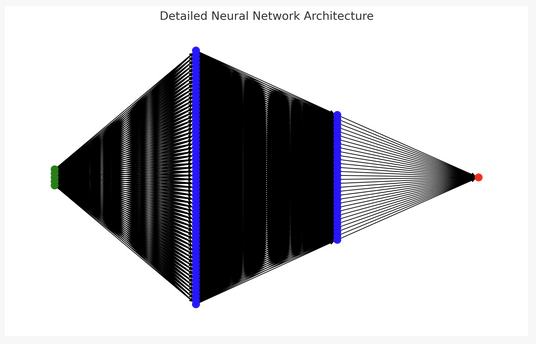

In [25]:
from keras.models import Sequential
from keras.layers import Dense

# Build a neural network model
nn_model = Sequential()
nn_model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))
nn_model.add(Dense(32, activation='relu'))
nn_model.add(Dense(1, activation='sigmoid'))

nn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
nn_model.fit(X_train_scaled, y_train, epochs=50, batch_size=10, verbose=1)

# Evaluate the model
_, accuracy = nn_model.evaluate(X_test_scaled, y_test)
print(f"Neural Network Accuracy: {accuracy}")

Epoch 1/50
70/70 [==============================] - 1s 3ms/step - loss: 0.5897 - accuracy: 0.6953
Epoch 2/50
70/70 [==============================] - 0s 3ms/step - loss: 0.4974 - accuracy: 0.7539
Epoch 3/50
70/70 [==============================] - 0s 3ms/step - loss: 0.4651 - accuracy: 0.7897
Epoch 4/50
70/70 [==============================] - 0s 3ms/step - loss: 0.4428 - accuracy: 0.8026
Epoch 5/50
70/70 [==============================] - 0s 3ms/step - loss: 0.4281 - accuracy: 0.8112
Epoch 6/50
70/70 [==============================] - 0s 3ms/step - loss: 0.4131 - accuracy: 0.8369
Epoch 7/50
70/70 [==============================] - 0s 3ms/step - loss: 0.3964 - accuracy: 0.8355
Epoch 8/50
70/70 [==============================] - 0s 3ms/step - loss: 0.3830 - accuracy: 0.8426
Epoch 9/50
70/70 [==============================] - 0s 2ms/step - loss: 0.3675 - accuracy: 0.8555
Epoch 10/50
70/70 [==============================] - 0s 3ms/step - loss: 0.3526 - accuracy: 0.8598
Epoch 11/50
70/70 [

Let's use a confusion matrix to visualize the performance of the neural network to the original decision tree (not the pruned tree).

Now let's look at a big brother to the confusion matrix, the ROC curve.

A ROC (Receiver Operating Characteristic) curve is a graphical tool used in binary classification to evaluate the performance of a classification model at various threshold settings. The ROC curve plots two parameters:

1. True Positive Rate (TPR): Also known as sensitivity, recall, or probability of detection, it measures the proportion of actual positives that are correctly identified by the model. It is calculated as the number of true positives divided by the sum of false negatives and true positives.
   
2. False Positive Rate (FPR): It measures the proportion of actual negatives that are incorrectly classified as positives by the model. It is calcualted as the number of false positives divided by the sum of false psotives and true negatives.

The ROC curve is created by plotting TPR against FPR at various threshold settings. By changing the threshold that determines how the model classifies a positive versus a negative, you can observe different balances between TPR and FPR. This "threshold" is built into the model - not the ROC curve! In other words, by using the ROC curve, we could go back to the model and change our classification theshold, print the ROC curve again, and then see if our results improve.

How do we interpret the ROC curve?

- Closer to the Left-Top Corner: Better Performance. If the curve is closer to the left-top corner of the plot, the classifier has a good measure of separability between the two classes. It means it can distinguish between the positive and negative classes well.
  
- Below the Line of No-discrimination: If the ROC curve falls below the line \( y = x \) (a 45-degree line from the bottom left to the top right corner), the classifier performs worse than random guessing.

Let's print the ROC curves and analyze them.

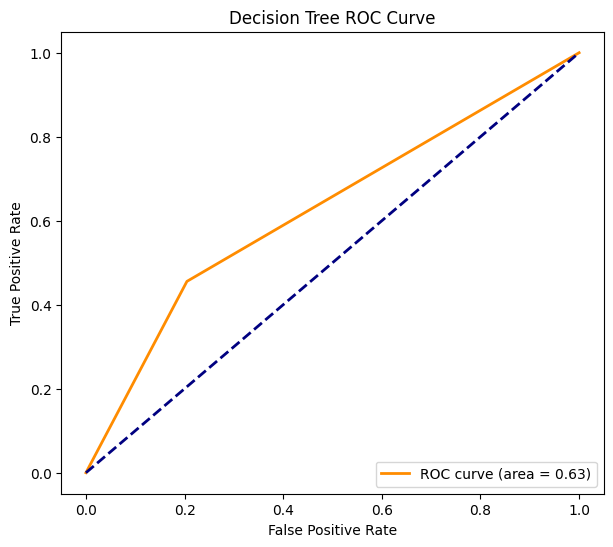

10/10 [==============================] - 1s 5ms/step


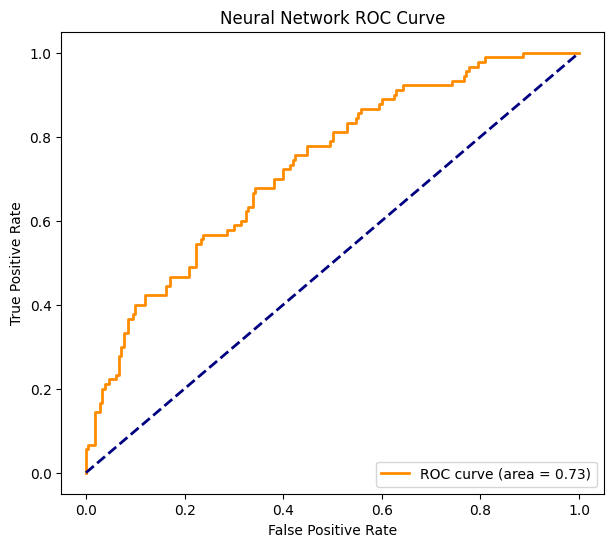

In [26]:
def plot_roc_curve(y_true, y_scores, title='ROC Curve'):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(7, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

# Plot ROC Curve for Decision Tree
y_scores_dt = dt_classifier.predict_proba(X_test_scaled)[:, 1]
plot_roc_curve(y_test, y_scores_dt, 'Decision Tree ROC Curve')

# Plot ROC Curve for Neural Network
y_scores_nn = nn_model.predict(X_test_scaled).ravel()
plot_roc_curve(y_test, y_scores_nn, 'Neural Network ROC Curve')

So which model was better according to the ROC curve?

Now, let' use a few more statistical metrics to evaluate the non-pruned decision tree and the neural network.

In [27]:
from sklearn.metrics import classification_report

# Print the classification report for Decision Tree
print("Decision Tree Classification Report:\n")
print(classification_report(y_test, y_pred_dt))

# Generate predictions and print classification report for Neural Network
nn_predictions = nn_model.predict(X_test_scaled)
nn_pred_classes = [1 if i > 0.5 else 0 for i in nn_predictions.ravel()]  # Convert probabilities to class labels

print("\nNeural Network Classification Report:\n")
print(classification_report(y_test, nn_pred_classes))


Decision Tree Classification Report:

              precision    recall  f1-score   support

           0       0.77      0.80      0.78       210
           1       0.49      0.46      0.47        90

    accuracy                           0.69       300
   macro avg       0.63      0.63      0.63       300
weighted avg       0.69      0.69      0.69       300

10/10 [==============================] - 0s 3ms/step

Neural Network Classification Report:

              precision    recall  f1-score   support

           0       0.78      0.82      0.80       210
           1       0.53      0.47      0.49        90

    accuracy                           0.71       300
   macro avg       0.65      0.64      0.65       300
weighted avg       0.70      0.71      0.71       300



Explanation of the metrics:

Precision (specifity) is the ratio of correctly predicted positive observations to the total predicted positives. High precision relates to a low false positive rate.

Recall (Sensitivity) is the ratio of correctly predicted positive observations to all actual positives. High recall indicates the model is good at detecting the positive class.

F1 Score is the weighted average of Precision and Recall. It's useful when you seek a balance between Precision and Recall.

"Support" is simply the number of true instances for each class in the test set or the dataset being evaluated. Here we are predicting whether a credit application is risky or not; the support for each class (risky, not risky) in the report is the number of actual samples of those classes in the test dataset.

Why is support a useful metric? If one class has significantly more samples than another, the model might be biased towards the majority class.

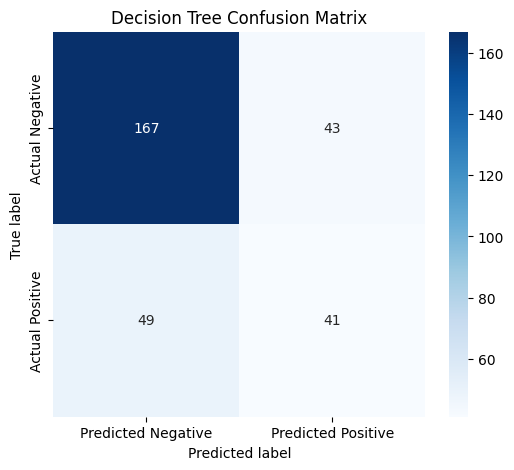

10/10 [==============================] - 0s 4ms/step


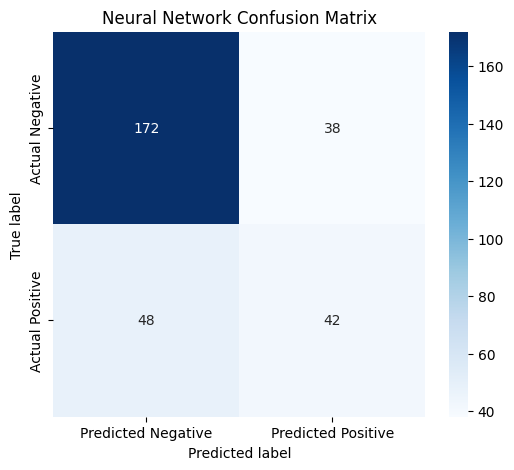

In [28]:

def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Predicted Negative", "Predicted Positive"],
                yticklabels=["Actual Negative", "Actual Positive"])
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Plot for Decision Tree
plot_confusion_matrix(y_test, y_pred_dt, title='Decision Tree Confusion Matrix')

# Predictions and plot for Neural Network
nn_predictions = nn_model.predict(X_test_scaled)
nn_pred_classes = [1 if i > 0.5 else 0 for i in nn_predictions.ravel()]  # Convert probabilities to class labels
plot_confusion_matrix(y_test, nn_pred_classes, title='Neural Network Confusion Matrix')

Could we change the architecture of the neural network to improve its performance?

How? Make it bigger? What does making it bigger mean in the context of a neural network?

But if we make it bigger, will it overfit like the decision tree overfits with more parameters? Thoughts?

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

nn_model = Sequential([
    Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

nn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
nn_model.fit(X_train_scaled, y_train, epochs=200, batch_size=32, verbose=1)

_, accuracy = nn_model.evaluate(X_test_scaled, y_test)
print(f"Neural Network Accuracy: {accuracy}")

Epoch 1/200
22/22 [==============================] - 9s 12ms/step - loss: 0.9504 - accuracy: 0.5422
Epoch 2/200
22/22 [==============================] - 0s 13ms/step - loss: 0.7719 - accuracy: 0.5980
Epoch 3/200
22/22 [==============================] - 0s 8ms/step - loss: 0.6858 - accuracy: 0.6652
Epoch 4/200
22/22 [==============================] - 0s 7ms/step - loss: 0.6435 - accuracy: 0.6795
Epoch 5/200
22/22 [==============================] - 0s 8ms/step - loss: 0.6204 - accuracy: 0.7067
Epoch 6/200
22/22 [==============================] - 0s 13ms/step - loss: 0.6008 - accuracy: 0.7325
Epoch 7/200
22/22 [==============================] - 0s 12ms/step - loss: 0.5735 - accuracy: 0.7225
Epoch 8/200
22/22 [==============================] - 0s 8ms/step - loss: 0.5718 - accuracy: 0.7182
Epoch 9/200
22/22 [==============================] - 0s 9ms/step - loss: 0.5437 - accuracy: 0.7325
Epoch 10/200
22/22 [==============================] - 0s 11ms/step - loss: 0.5271 - accuracy: 0.7654
Epoc

Below is a summary of our key changes. We won't go into the details, but notice that the dropout layer is designed to combat overfitting! So, overfitting is still a concern with training a neural network.

Increased Neurons: The input layer and the hidden layer have more neurons (64 and 32, respectively), theoretically increasing the model's capacity to learn.
    
Added Batch Normalization: Helps in normalizing the input of each layer to speed up training and improve overall performance.

Added Dropout: Introduces a 30% dropout rate after batch normalization layers to help prevent overfitting by reducing the dependence on any single neuron.

Increased Training Epochs: Increased the number of epochs to 200 to provide the larger network more opportunity to learn from data.

Despite this, our performance went down! The takeaway is that neural network architecture design is tough and it involves a lot of experimenting.

In [30]:
# Original Model
model_original = Sequential([
    Dense(12, input_dim=24, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [31]:
# Modified Model with Additional Layers
model_modified = Sequential([
    Dense(64, input_dim=24, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [32]:
print("Original Neural Network Model:")
model_original.summary()

print("\nModified Neural Network Model:")
model_modified.summary()

Original Neural Network Model:
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 12)                300       
                                                                 
 dense_23 (Dense)            (None, 1)                 13        
                                                                 
Total params: 313 (1.22 KB)
Trainable params: 313 (1.22 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Modified Neural Network Model:
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 64)                1600      
                                                                 
 dense_25 (Dense)            (None, 32)                2080      
     

This is helpful to print, but it's usually much more helpful to visualize the architecture (a picture is worth a thousand words right?).

In [33]:
model_modified.save("model_modified.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [34]:
from google.colab import files
files.download('model_modified.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Now let's visualize the new neural network architecture on Netron: https://netron.app/ !

**Homework:**

(1) Please experiment with new neural network architectures for the credit decision model. Add layers, epochs, or change their structure in the code above. Write a paragraph summarizing -- structure of the network and its efficiency.
Email prof Holmes with your answer!